In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor

#### Data Import (Preprocessed using R)

In [2]:
encoded_results = pd.read_csv("oh_encoded_classification_data_65.txt" , sep = "\t")
encoded_results_80 = pd.read_csv("oh_encoded_classification_data_80.txt" , sep = "\t")

In [3]:
encoded_results.head()

,Number_of_Neighbours,Number_of_PCs,Number_of_Cells,Number_of_HVGs,Algorithm.Leiden,Algorithm.Louvain,Algorithm.Walktrap,Exp_Type.Droplet,acceptable_ari
0,1,15,2500,500,0,0,1,1,0
1,2,15,2500,500,0,0,1,1,0
2,3,15,2500,500,0,0,1,1,0
3,4,15,2500,500,0,0,1,1,0
4,5,15,2500,500,0,0,1,1,0


In [4]:
labels = encoded_results["acceptable_ari"]
labels_80 = encoded_results_80["acceptable_ari"]

In [5]:
features = encoded_results.drop(["acceptable_ari"] , axis = 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, labels ,test_size=.25,random_state = 25)

In [7]:
y_train.sum()

5589

In [8]:
y_test.sum()

1864

#### RandomForest Algorithm

In [9]:
rf_model = RandomForestRegressor()

In [ ]:
rf_params = {"max_depth" : [3,5,7,8,10,12,15] , "max_features" : [2,3,5,10,12,15] , 
             "n_estimators": [50,100,200,400,500,800,1000,2000], 
             "min_samples_split":[2,3,5,10,15,20,50,80,100]}

In [ ]:
rf_cv_model = GridSearchCV(rf_model, rf_params , 
                           cv = 10, n_jobs = 8 , verbose = 2).fit(X_train,y_train)

In [ ]:
rf_cv_model.best_params_

In [10]:
rf_tuned = RandomForestRegressor(max_depth = 15 , max_features = 5, 
                                 min_samples_split = 3 , n_estimators = 400).fit(X_train , y_train)

In [11]:
y_pred = rf_tuned.predict(X_test)

In [12]:
min(y_pred)

0.0

In [13]:
accuracy_score(y_test, np.rint(y_pred))

0.9753929539295393

In [14]:
y_test_80 = labels_80[y_test.index]

In [15]:
accuracy_score(y_test_80, np.rint(np.absolute(y_pred)))

0.8662330623306234

In [16]:
confusion_matrix(y_test, np.rint(y_pred))

array([[7267,   94],
       [ 133, 1731]])

In [17]:
confusion_matrix(y_test_80, np.rint(np.absolute(y_pred)))

array([[7392, 1226],
       [   8,  599]])

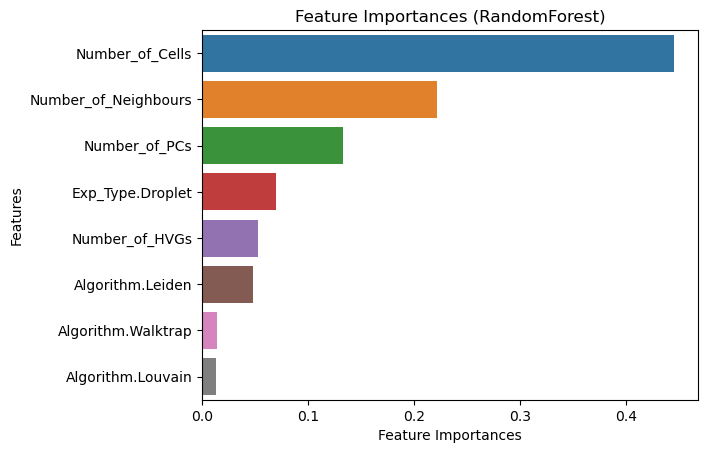

In [18]:
import seaborn as sns

feature_imp = pd.Series(rf_tuned.feature_importances_,
                        index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importances')
plt.ylabel('Features')
plt.title("Feature Importances (RandomForest)")
plt.show()

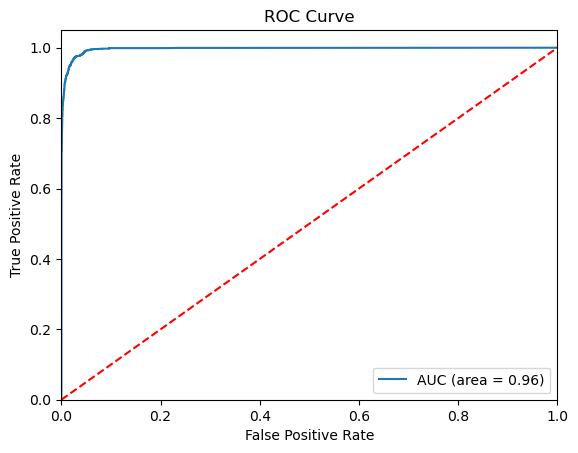

In [19]:
logit_roc_auc = roc_auc_score(y_test, np.rint(np.absolute(rf_tuned.predict(X_test))))
fpr, tpr, thresholds = roc_curve(y_test, np.absolute(rf_tuned.predict(X_test)))
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

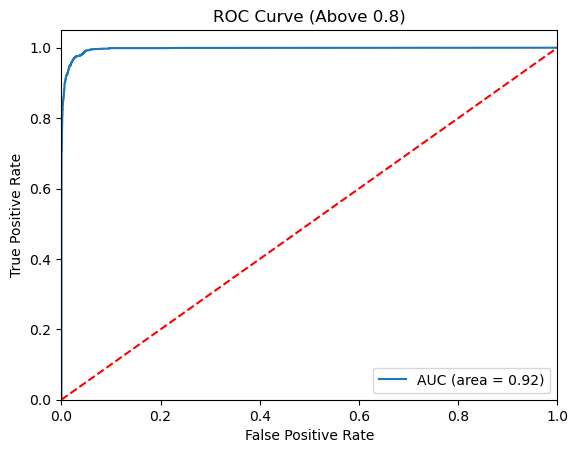

In [20]:
logit_roc_auc_80 = roc_auc_score(y_test_80, np.rint(np.absolute(y_pred)))
fpr_80, tpr_80, thresholds_80 = roc_curve(y_test_80, np.absolute(y_pred))
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc_80)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Above 0.8)')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [21]:
thresholds[np.argmax(tpr - fpr)]

0.22269511286702798

In [22]:
thresholds_80[np.argmax((tpr_80) - (fpr_80))]

0.8605687058153348

In [23]:
y_pred_corrected = (rf_tuned.predict(X_test) >= thresholds[np.argmax(tpr - fpr)]).astype(bool)

In [24]:
accuracy_score(y_test, y_pred_corrected)

0.971490514905149

In [25]:
confusion_matrix(y_test, y_pred_corrected)

array([[7144,  217],
       [  46, 1818]])

In [ ]:
logit_roc_auc = roc_auc_score(y_test, rf_tuned.predict(X_test) >= thresholds[np.argmax(tpr - fpr)]).astype(bool)
fpr, tpr, thresholds = roc_curve(y_test, np.absolute(y_pred))
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [28]:
import pickle

In [29]:
filename = 'rf_model_65.sav'
pickle.dump(rf_tuned, open(filename, 'wb'))